# 鸡蛋产业链期货套利策略

## ——跨品种统计套利

### 詹梓乐 修改于2023-05-17

In [3]:
# 导入函数包

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import adfuller
from matplotlib.patches import Rectangle
import warnings
warnings.filterwarnings("ignore")

In [4]:
# 导入数据集

jd = pd.read_csv('R.CN.DCE.jd.0004.csv', index_col='CLOCK', parse_dates=True)
c = pd.read_csv('R.CN.DCE.c.0004.csv', index_col='CLOCK', parse_dates=True)
m = pd.read_csv('R.CN.DCE.m.0004.csv', index_col='CLOCK', parse_dates=True)

## 数据处理与价差构建

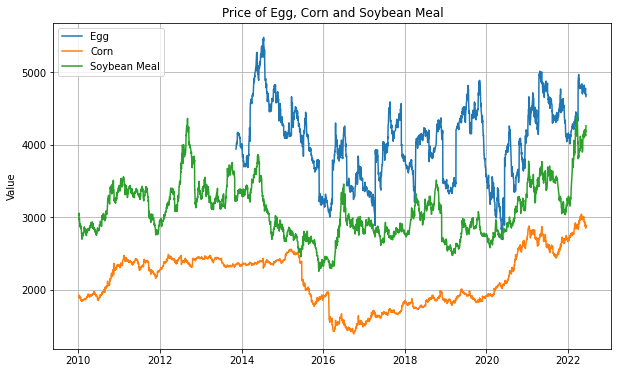

In [3]:
# 数据观察

plt.figure(figsize=(10,6))
plt.plot(jd['CLOSE'], label='Egg')
plt.plot(c['CLOSE'], label='Corn')
plt.plot(m['CLOSE'], label='Soybean Meal')
plt.ylabel('Value')
plt.title('Price of Egg, Corn and Soybean Meal')
plt.legend()
plt.grid()
plt.show()

In [5]:
c = c[c.index>='2013-11-11']
m = m[m.index>='2013-11-11']

In [6]:
# 价差配比构建

pair = pd.DataFrame({'jd': jd['CLOSE'], 'c': c['CLOSE'], 'm': m['CLOSE']})
results = smf.ols('jd ~ c + m', pair).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     jd   R-squared:                       0.366
Model:                            OLS   Adj. R-squared:                  0.366
Method:                 Least Squares   F-statistic:                     603.6
Date:                Fri, 19 May 2023   Prob (F-statistic):          1.43e-207
Time:                        19:20:42   Log-Likelihood:                -15550.
No. Observations:                2090   AIC:                         3.111e+04
Df Residuals:                    2087   BIC:                         3.112e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1811.8649     71.277     25.420      0.000    1672.084    1951.646
c              0.4198      0.028     14.749      0.000       0.364       0.476
m              0.4513      0.031     14.747      0.000       0.391       0.511
==============================================================================
Omnibus:                       14.777   Durbin-Watson:                   0.034
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               10.555
Skew:                           0.037   Prob(JB):                      0.00511
Kurtosis:                       2.660   Cond. No.                     2.92e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.92e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [7]:
# ADF测试功能

def run_adf(timeseries):
    # Perform the Augmented Dickey-Fuller test
    result = adfuller(timeseries, regression = "ct")
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

In [8]:
run_adf(results.resid)

ADF Statistic: -4.174101
p-value: 0.004897
Critical Values:
	1%: -3.963
	5%: -3.413
	10%: -3.128


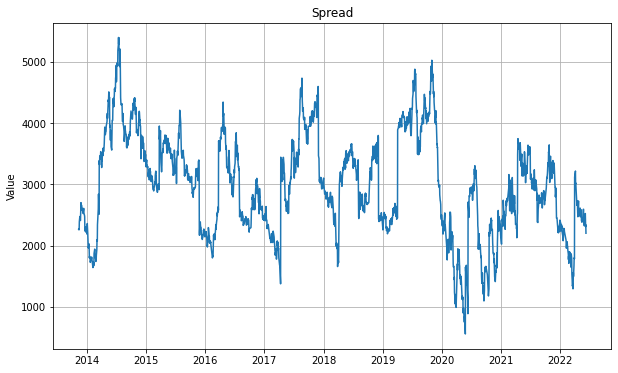

In [7]:
asset1 = 2 * jd
asset2 = c + m
plt.figure(figsize=(10,6))
plt.plot(asset1['CLOSE']-asset2['CLOSE'])
plt.ylabel('Value')
plt.title('Spread')
plt.grid()
plt.show()

In [10]:
# 对应配比的期货合约数据相关性较高

asset1['CLOSE'].corr(asset2['CLOSE'])

0.6052667211070792

In [20]:
# 检测价差时间序列数据是否平稳

run_adf((asset1['CLOSE']-asset2['CLOSE']).dropna())

ADF Statistic: -4.236286
p-value: 0.003944
Critical Values:
	1%: -3.963
	5%: -3.413
	10%: -3.128


测试表明，对应配比的期货合约数据不具有单位根，具有协整关系。

## 主策略构建

In [8]:
# 数据预处理

jd = jd[jd.index>='2015-02-01']
jd = jd[jd.index<='2022-02-01']
c = c[c.index>='2015-02-01']
c = c[c.index<='2022-02-01']
m = m[m.index>='2015-02-01']
m = m[m.index<='2022-02-01']
arbitrage = asset1[['CLOSE']] - asset2[['CLOSE']]
arbitrage = arbitrage[arbitrage.index>='2015-02-01']
arbitrage = arbitrage[arbitrage.index<='2022-02-01']

In [9]:
# 计算夏普比率(用于后续敏感性分析)

def sharpe(df):
    absolute_return = sum(df['Daily Return'])
    annual_return = absolute_return * 252/len(df)
    volatility = df['Daily Return'].std() * np.sqrt(252)
    sharpe = annual_return / volatility
    return sharpe

In [1]:
# 主策略部分-买入卖出价差和止损信号识别、回报计算

list1 = []
def pair_trading(df,zscore,window,maxdown):
    df["Mean"] = df['CLOSE'].ewm(window).mean()
    df["STD"] = df['CLOSE'].ewm(window).std()
    df["Lower Bound"] = df["Mean"] - zscore * df["STD"]
    df["Upper Bound"] = df["Mean"] + zscore * df["STD"]
    df['Signals'] = 0.
    
    df['Egg'] = jd['CLOSE']
    df['Corn'] = c['CLOSE']
    df['Soybean Meal'] = m['CLOSE']
    df['Portfolio Returns'] = 0.
    df['Daily Return'] = 0.
    df['trade'] = 0
    df['hold'] = 0
    df.index = pd.DatetimeIndex(df.index).date
    
    position = 0.
    Capital = 1000000
    last_place = "BTWN" # Last place分别为under lower bound, between bounds, above upper bounds
    jd_return = 0
    c_return = 0
    m_return = 0
    jd_lot = 0
    c_lot = 0
    m_lot = 0
    
    for i in range(1,len(df)):  
        
        # 检查价差是否跨过上下界限
        if df['CLOSE'][i] > df["Upper Bound"][i] and position == 0:
            last_place = "UP"
        elif df['CLOSE'][i] < df["Lower Bound"][i] and position == 0:
            last_place = "DOWN"
            
        # 【退出信号】价差回归到加权移动平均线进行平仓
        if last_place == "UP BTWN" and position == -1. and df['CLOSE'][i] <= df["Mean"][i]:
            position = 0.
            df['Signals'][i]=-1
            jd_return = -jd_lot * (df['Egg'][i] - df['Egg'][i-1])
            c_return = c_lot * (df['Corn'][i] - df['Corn'][i-1])
            m_return = m_lot * (df['Soybean Meal'][i] - df['Soybean Meal'][i-1])
            df['Portfolio Returns'][i] = jd_return + c_return + m_return
            df['Daily Return'][i] = df['Portfolio Returns'][i]/Capital
            last_place = "DOWN BTWN"
            df['trade'][i] = 1
            df['hold'][i] = 1
            print('【平仓】买入平仓于', df.index[i])
        elif last_place == "DOWN BTWN" and position == 1. and df['CLOSE'][i] >= df["Mean"][i]:
            position = 0.
            df['Signals'][i]=1
            jd_return = jd_lot * (df['Egg'][i] - df['Egg'][i-1])
            c_return = -c_lot * (df['Corn'][i] - df['Corn'][i-1])
            m_return = -m_lot * (df['Soybean Meal'][i] - df['Soybean Meal'][i-1])
            df['Portfolio Returns'][i] = jd_return + c_return + m_return
            df['Daily Return'][i] = df['Portfolio Returns'][i]/Capital
            last_place = "UP BTWN"
            df['trade'][i] = 1
            df['hold'][i] = 1
            print('【平仓】卖出平仓于', df.index[i])
            
        # 【持仓】持仓期间计算每日资产变动
        if last_place == "UP BTWN" and position == -1.:
            df['Signals'][i]=position
            jd_return = -jd_lot * (df['Egg'][i] - df['Egg'][i-1])
            c_return = c_lot * (df['Corn'][i] - df['Corn'][i-1])
            m_return = m_lot * (df['Soybean Meal'][i] - df['Soybean Meal'][i-1])
            df['Portfolio Returns'][i] = jd_return + c_return + m_return
            df['Daily Return'][i] = df['Portfolio Returns'][i]/Capital
            df['hold'][i] = 1
        elif last_place == "DOWN BTWN"  and position == 1.:
            df['Signals'][i]=position  
            df['Signals'][i]=1
            jd_return = jd_lot * (df['Egg'][i] - df['Egg'][i-1])
            c_return = -c_lot * (df['Corn'][i] - df['Corn'][i-1])
            m_return = -m_lot * (df['Soybean Meal'][i] - df['Soybean Meal'][i-1])
            df['Portfolio Returns'][i] = jd_return + c_return + m_return
            df['Daily Return'][i] = df['Portfolio Returns'][i]/Capital
            df['hold'][i] = 1
            
        # 【建仓信号】价差两次触及加权移动平均值加1倍标准差界限时进行建仓
        if last_place == "UP" and df['CLOSE'][i] < df["Upper Bound"][i]:
            position = -1.
            df['Signals'][i]=-1.
            last_place = "UP BTWN"
            c_lot = Capital/(df['Corn'][i] + df['Soybean Meal'][i]) 
            m_lot = Capital/(df['Corn'][i] + df['Soybean Meal'][i])
            jd_lot = 2 * c_lot
            df['trade'][i] = 1
            print("【建仓】做空价差于", df.index[i], '买入', c_lot, '手玉米', m_lot, '手豆粕')
        elif last_place == "DOWN" and df['CLOSE'][i] > df["Lower Bound"][i]:
            position = 1.
            df['Signals'][i]=1.
            last_place = "DOWN BTWN"
            jd_lot = Capital/df['Egg'][i]
            c_lot = 0.5 * jd_lot
            m_lot = 0.5 * jd_lot
            df['trade'][i] = 1
            print("【建仓】做多价差于", df.index[i], '买入', jd_lot, '手鸡蛋')
            
        # 【退出信号】仓位触及止损点进行平仓
        if df['Portfolio Returns'][i] < maxdown * Capital:
            df['Portfolio Returns'][i] = maxdown * Capital
            df['Daily Return'][i] = maxdown
            df['Signals'][i]= 0 
            position = 0
            if last_place =='UP BTWN':
                last_place = 'UP'
            elif last_place =='DOWN BTWN':
                ast_place = 'DOWN'
            df['trade'][i] = 1
            print('【平仓】触及止损点平仓于', df.index[i])
        
    # 生成各个指标列表
    parameter = [zscore, window, maxdown, sharpe(df)]
    list1.append(parameter)
    
    return df

## 策略回测（2015年-2022年）

In [10]:
# 使用主策略功能进行一次回测
pair_trading(df=arbitrage, zscore=1, window=15, maxdown=-0.01)

【建仓】做多价差于 2015-02-25 买入 238.2654276864427 手鸡蛋
【平仓】卖出平仓于 2015-02-27
【建仓】做空价差于 2015-03-04 买入 186.21973929236498 手玉米 186.21973929236498 手豆粕
【平仓】买入平仓于 2015-03-06
【建仓】做多价差于 2015-03-16 买入 240.44241404183697 手鸡蛋
【平仓】卖出平仓于 2015-03-18
【建仓】做空价差于 2015-04-01 买入 188.1821603312006 手玉米 188.1821603312006 手豆粕
【平仓】买入平仓于 2015-04-07
【建仓】做多价差于 2015-06-24 买入 247.09661477637755 手鸡蛋
【平仓】卖出平仓于 2015-06-25
【建仓】做多价差于 2015-07-06 买入 247.52475247524754 手鸡蛋
【平仓】触及止损点平仓于 2015-07-08
【建仓】做空价差于 2015-08-03 买入 213.67521367521368 手玉米 213.67521367521368 手豆粕
【平仓】买入平仓于 2015-08-05
【建仓】做多价差于 2015-08-31 买入 255.3626149131767 手鸡蛋
【平仓】触及止损点平仓于 2015-09-15
【建仓】做多价差于 2015-09-18 买入 259.53802232026993 手鸡蛋
【平仓】触及止损点平仓于 2015-10-12
【建仓】做多价差于 2015-10-20 买入 274.64982147761606 手鸡蛋
【平仓】卖出平仓于 2015-11-03
【建仓】做空价差于 2015-11-09 买入 229.20009168003668 手玉米 229.20009168003668 手豆粕
【平仓】触及止损点平仓于 2015-11-11
【建仓】做空价差于 2015-11-12 买入 229.9908003679853 手玉米 229.9908003679853 手豆粕
【平仓】买入平仓于 2015-11-17
【建仓】做空价差于 2015-11-25 买入 238.83448770002389 手玉米 238.834487700023

,CLOSE,Mean,STD,Lower Bound,Upper Bound,Signals,Egg,Corn,Soybean Meal,Portfolio Returns,Daily Return,trade,hold
2015-02-02,3045.0,3045.000000,NaN,NaN,NaN,0.0,4089.0,2468.0,2665.0,0.0,0.0,0,0
2015-02-03,3146.0,3097.129032,71.417785,3025.711247,3168.546817,0.0,4159.0,2481.0,2691.0,0.0,0.0,0,0
2015-02-04,3070.0,3087.496533,52.164528,3035.332004,3139.661061,0.0,4144.0,2498.0,2720.0,0.0,0.0,0,0
2015-02-05,3138.0,3101.369660,49.332648,3052.037012,3150.702308,0.0,4173.0,2492.0,2716.0,0.0,0.0,0,0
2015-02-06,3107.0,3102.645554,42.096765,3060.548789,3144.742320,0.0,4168.0,2504.0,2725.0,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-24,2281.0,2364.195153,312.535285,2051.659868,2676.730439,0.0,4133.0,2732.0,3253.0,0.0,0.0,0,0
2022-01-25,2228.0,2355.682956,304.461002,2051.221954,2660.143958,0.0,4117.0,2758.0,3248.0,0.0,0.0,0,0
2022-01-26,2241.0,2348.515271,296.140666,2052.374606,2644.655937,0.0,4138.0,2775.0,3260.0,0.0,0.0,0,0
2022-01-27,2266.0,2343.358067,287.454932,2055.903135,2630.812999,0.0,4186.0,2768.0,3338.0,0.0,0.0,0,0


In [11]:
# 生成价差、均线、上下界及交易信号图

def spread_trading_plot(df):
    plt.figure(figsize = (10,6))
    plt.plot(df["Mean"])
    plt.plot(df['CLOSE'])
    plt.plot(df["Upper Bound"], color = "blue", linestyle = "dotted")
    plt.plot(df["Lower Bound"], color = "blue", linestyle = "dotted")
    plt.title("Spread of Egg, Corn and Soybean Meal")
    plt.legend(["Mean", "Spread", "Bounds"])
    plt.grid()
    plt.show()
    
    plt.figure(figsize = (10,6))
    plt.plot(df["Signals"])
    plt.title('Signals of Longing or Shorting Spread')
    plt.grid()
    plt.show()

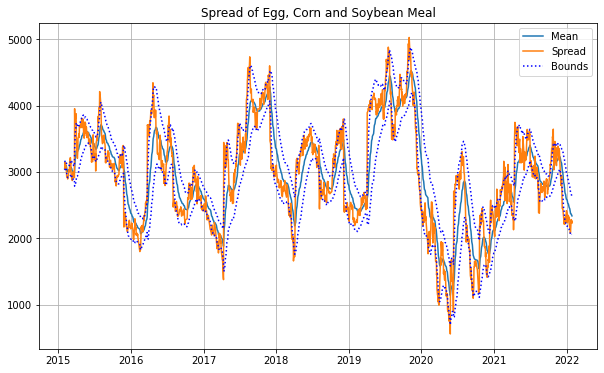

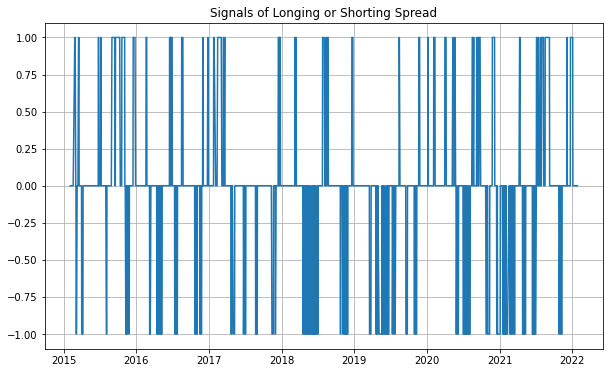

In [12]:
spread_trading_plot(df=arbitrage)

In [13]:
# 生成买入及卖出信号模拟图

def signals_plots(df):

    buy_signals = df['Signals'] == 1.0
    sell_signals = df['Signals'] == -1.0

    # 绘制买入信号模拟图
    fig = plt.figure(figsize = (10,6))
    plt.plot(jd['CLOSE'], label='Egg', color='blue', linewidth=1)
    plt.plot(c['CLOSE'], label='Corn', color='orange', linewidth=1)
    plt.plot(m['CLOSE'], label='Soybean Meal',  color='purple', linewidth=1)
    plt.fill_between(arbitrage.index, 6000, where=buy_signals, facecolor='green', alpha=0.5)
    plt.title('Long Spread Signals Plot')
    plt.legend()
    plt.grid()
    plt.show()
    
    # 绘制卖出信号模拟图
    fig = plt.figure(figsize = (10,6))
    plt.plot(jd['CLOSE'], label='Egg', color='blue', linewidth=1)
    plt.plot(c['CLOSE'], label='Corn', color='orange', linewidth=1)
    plt.plot(m['CLOSE'], label='Soybean Meal',  color='purple', linewidth=1)
    plt.fill_between(arbitrage.index, 6000, where=sell_signals, facecolor='red', alpha=0.5)
    plt.title('Sell Spread Signals Plot')
    plt.legend()
    plt.grid()
    plt.show()
    
    # 绘制简单模拟仓位图
    fig = plt.figure(figsize = (10,6))
    plt.plot(jd['CLOSE'], label='Egg', color='blue', linewidth=1)
    plt.plot(c['CLOSE'], label='Corn', color='orange', linewidth=1)
    plt.plot(m['CLOSE'], label='Soybean Meal',  color='purple', linewidth=1)
    plt.fill_between(arbitrage.index, 3000, 6000, where=buy_signals, facecolor='green', alpha=0.5)
    plt.fill_between(arbitrage.index, 0, 3000, where=sell_signals, facecolor='red', alpha=0.5)
    plt.title('Simulated Position Plot')
    plt.legend()
    plt.grid()
    plt.show()

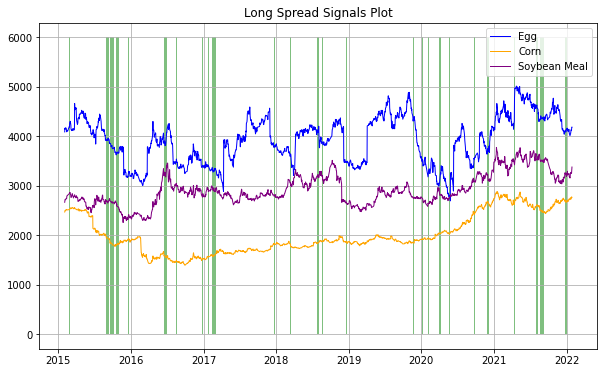

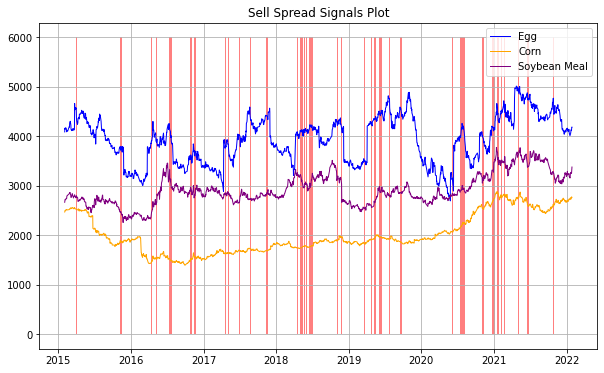

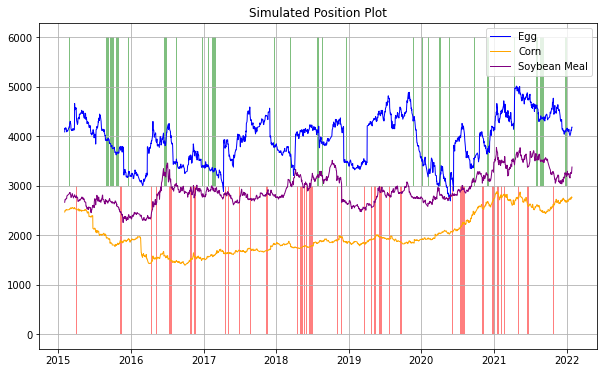

In [14]:
signals_plots(arbitrage)

## 策略回测表现（选取夏普比率最优策略）

In [15]:
# 策略回测表现功能：PNL曲线、收益率、夏普比率、最大回撤率等指标

def ratio_table(df):
    
    # PNL曲线
    plt.figure(figsize=(10,6))
    plt.plot((df['Portfolio Returns']).cumsum())
    plt.title('Profit and Loss Plot')
    plt.ylabel('Profit and Loss')
    plt.grid()
    plt.show()
    
    # 绝对收益率
    absolute_return = sum(df['Daily Return'])
    
    # 年化收益率
    annual_return = absolute_return * 252/len(df)
    
    # 年化波动率
    volatility = df['Daily Return'].std() * np.sqrt(252)
    
    # 夏普比率
    sharpe = annual_return / volatility
    
    # 最大回撤率
    cumulative_returns = df['Daily Return'].cumsum()
    peak = cumulative_returns.expanding().max()
    peak = peak[peak != 0]
    drawdown = (cumulative_returns - peak) / peak
    max_drawdown = drawdown.dropna().min()
    
    # 最大回撤时间
    maxdrawdown_time = drawdown[drawdown == max_drawdown].index[0].strftime('%Y-%m-%d')
    
    # Calmer
    calmar = annual_return/np.abs(max_drawdown)
    
    # 胜率
    profitable_trades = 0
    total_trades = 0
    for trade in df[df['Portfolio Returns']!=0]['Portfolio Returns']:
        total_trades += 1
        if trade > 0:
            profitable_trades += 1
    win_rate = profitable_trades / total_trades
    
    # 盈亏比
    profit_sum = 0
    loss_sum = 0
    num_profit_trades = 0
    num_loss_trades = 0
    for trade in df[df['Portfolio Returns']!=0]['Portfolio Returns']:
        if trade > 0:
            profit_sum += trade
            num_profit_trades += 1
        else:
            loss_sum += trade
            num_loss_trades += 1    
    profit_loss_ratio = (profit_sum/num_profit_trades) / ((-1 * loss_sum)/num_loss_trades)
    
    # 平均持有期
    avg_holding_period = sum(df['hold'])/sum(df['trade'])
    
    data = [absolute_return,annual_return,volatility,sharpe,max_drawdown,calmar,win_rate,profit_loss_ratio,avg_holding_period,maxdrawdown_time]
    index = ['absolute_return','annual_return','volatility','sharpe','max_drawdown','calmar','win_rate','profit_loss_ratio','avg_holding_period','maxdrawdown_time']
    column = ['Ratios']
    ratio_table = pd.DataFrame(data=data,index=index,columns =column)
    
    return ratio_table

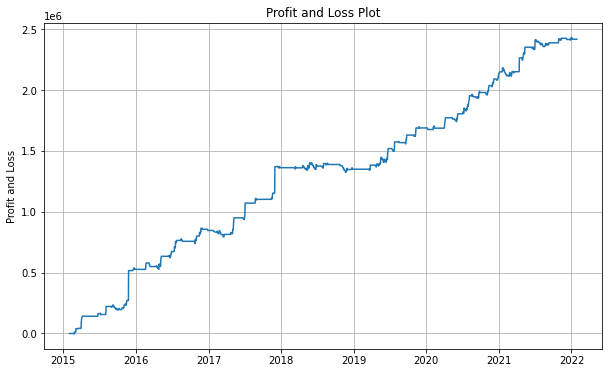

,Ratios
absolute_return,2.416534
annual_return,0.357375
volatility,0.188733
sharpe,1.893544
max_drawdown,-0.177118
calmar,2.017721
win_rate,0.485126
profit_loss_ratio,2.680125
avg_holding_period,1.47973
maxdrawdown_time,2015-09-30


In [16]:
ratio_table(df=arbitrage)

## 参数敏感性分析

In [116]:
# Z-score和Windows敏感性分析及最优选择

input1 = [[0.5,5],[0.5,10],[0.5,15],[0.5,20],[0.5,25],[0.5,30],
          [1,5],[1,10],[1,15],[1,20],[1,25],[1,30],
          [1.5,5],[1.5,10],[1.5,15],[1.5,20],[1.5,25],[1.5,30],
          [2,5],[2,10],[2,15],[2,20],[2,25],[2,30]]
for element in input1:
    pair_trading(df=arbitrage, zscore=element[0], window=element[1], maxdown=-0.01)

【建仓】做空价差于 2015-02-04 买入 191.64430816404752 手玉米 191.64430816404752 手豆粕
【平仓】触及止损点平仓于 2015-02-05
【建仓】做空价差于 2015-02-06 买入 190.63642549537067 手玉米 190.63642549537067 手豆粕
【平仓】买入平仓于 2015-02-09
【建仓】做空价差于 2015-02-26 买入 186.55313457863244 手玉米 186.55313457863244 手豆粕
【平仓】触及止损点平仓于 2015-02-27
【建仓】做空价差于 2015-03-04 买入 183.47136017109605 手玉米 183.47136017109605 手豆粕
【平仓】买入平仓于 2015-03-06
【建仓】做多价差于 2015-03-16 买入 243.2903465601334 手鸡蛋
【平仓】卖出平仓于 2015-03-17
【建仓】做空价差于 2015-04-01 买入 190.04483036716482 手玉米 190.04483036716482 手豆粕
【平仓】买入平仓于 2015-04-02
【建仓】做多价差于 2015-04-09 买入 249.64838143469925 手鸡蛋
【平仓】卖出平仓于 2015-04-10
【建仓】做空价差于 2015-04-27 买入 207.66747153471744 手玉米 207.66747153471744 手豆粕
【平仓】触及止损点平仓于 2015-04-28
【建仓】做空价差于 2015-04-30 买入 204.09474018642476 手玉米 204.09474018642476 手豆粕
【平仓】触及止损点平仓于 2015-05-05
【建仓】做空价差于 2015-05-06 买入 202.04834506985574 手玉米 202.04834506985574 手豆粕
【平仓】买入平仓于 2015-05-08
【建仓】做多价差于 2015-05-21 买入 249.36287725249855 手鸡蛋
【平仓】卖出平仓于 2015-05-22
【建仓】做多价差于 2015-05-27 买入 254.94693048698417 手鸡蛋
【平仓】触及止损点平

In [126]:
list1
column3 = [['Zscore', 'Windows', 'Maxdown', 'Sharpe']]
test = pd.DataFrame(list1, columns=column3)
test = test.iloc[1:]
test

,Zscore,Windows,Maxdown,Sharpe
1,0.5,5,-0.01,1.390772
2,0.5,10,-0.01,1.290809
3,0.5,15,-0.01,1.039342
4,0.5,20,-0.01,0.971015
5,0.5,25,-0.01,0.964869
6,0.5,30,-0.01,0.849121
7,1.0,5,-0.01,1.769045
8,1.0,10,-0.01,1.829776
9,1.0,15,-0.01,1.880233
10,1.0,20,-0.01,1.782807


In [127]:
# 参数敏感性分析热力图

def Sensitivity(df):
    sensitivity = df.loc[:, ['Zscore','Windows','Sharpe']]
    sensitivity = pd.pivot_table(data=sensitivity, values='Sharpe', columns=sensitivity['Zscore'], index=sensitivity['Windows'])
    ax = sns.heatmap(sensitivity, cmap='YlGnBu', annot=True, fmt='.2f')
    plt.title('Parameter Sensitivity Analysis Heatmap')
    plt.xlabel('Zscore')
    plt.ylabel('Windows')
    plt.show()

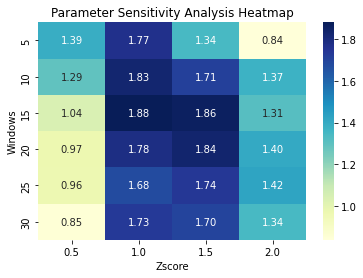

In [128]:
Sensitivity(test)

In [ ]:
# 不同参数的PNL曲线--Z-score，Windows和止损点的敏感性分析

In [139]:
pair_trading(df=arbitrage, zscore=1, window=10, maxdown=-0.01)
test1 = arbitrage[['Portfolio Returns']]

【建仓】做多价差于 2015-02-25 买入 238.2654276864427 手鸡蛋
【平仓】卖出平仓于 2015-02-26
【建仓】做空价差于 2015-03-04 买入 185.46545395332038 手玉米 185.46545395332038 手豆粕
【平仓】买入平仓于 2015-03-06
【建仓】做多价差于 2015-03-13 买入 248.14215879489615 手鸡蛋
【平仓】卖出平仓于 2015-03-18
【建仓】做空价差于 2015-04-01 买入 195.51584848969324 手玉米 195.51584848969324 手豆粕
【平仓】买入平仓于 2015-04-03
【建仓】做多价差于 2015-06-08 买入 266.0849962930579 手鸡蛋
【平仓】触及止损点平仓于 2015-06-12
【建仓】做多价差于 2015-06-24 买入 275.7849022735657 手鸡蛋
【平仓】卖出平仓于 2015-06-25
【建仓】做多价差于 2015-07-03 买入 282.4113911317613 手鸡蛋
【平仓】触及止损点平仓于 2015-07-08
【建仓】做空价差于 2015-07-15 买入 232.16569779290208 手玉米 232.16569779290208 手豆粕
【平仓】触及止损点平仓于 2015-07-17
【建仓】做空价差于 2015-07-30 买入 241.89169198143125 手玉米 241.89169198143125 手豆粕
【平仓】触及止损点平仓于 2015-07-31
【建仓】做空价差于 2015-08-03 买入 241.49164033700043 手玉米 241.49164033700043 手豆粕
【平仓】买入平仓于 2015-08-05
【建仓】做多价差于 2015-08-31 买入 307.5996685395705 手鸡蛋
【平仓】触及止损点平仓于 2015-09-15
【建仓】做多价差于 2015-09-17 买入 310.35296913021165 手鸡蛋
【平仓】触及止损点平仓于 2015-10-12
【建仓】做多价差于 2015-10-20 买入 325.12179835194917 手鸡蛋
【平仓】卖出平仓于

In [140]:
pair_trading(df=arbitrage, zscore=1, window=20, maxdown=-0.01)
test2 = arbitrage[['Portfolio Returns']]

【建仓】做多价差于 2015-02-25 买入 238.2654276864427 手鸡蛋
【平仓】卖出平仓于 2015-02-27
【建仓】做空价差于 2015-03-04 买入 188.57133476115112 手玉米 188.57133476115112 手豆粕
【平仓】买入平仓于 2015-03-06
【建仓】做多价差于 2015-03-16 买入 250.05311642407992 手鸡蛋
【平仓】卖出平仓于 2015-03-18
【建仓】做空价差于 2015-04-02 买入 196.00028110684457 手玉米 196.00028110684457 手豆粕
【平仓】买入平仓于 2015-04-07
【建仓】做空价差于 2015-04-29 买入 208.40251644356135 手玉米 208.40251644356135 手豆粕
【平仓】触及止损点平仓于 2015-05-05
【建仓】做空价差于 2015-05-06 买入 209.8444472961327 手玉米 209.8444472961327 手豆粕
【平仓】买入平仓于 2015-05-11
【建仓】做多价差于 2015-06-24 买入 284.04444830447613 手鸡蛋
【平仓】卖出平仓于 2015-06-25
【建仓】做多价差于 2015-07-06 买入 290.6534032897783 手鸡蛋
【平仓】触及止损点平仓于 2015-07-08
【建仓】做空价差于 2015-08-04 买入 243.49448884995556 手玉米 243.49448884995556 手豆粕
【平仓】买入平仓于 2015-08-06
【建仓】做多价差于 2015-08-31 买入 311.4565614528671 手鸡蛋
【平仓】触及止损点平仓于 2015-09-15
【建仓】做多价差于 2015-09-18 买入 314.081268058207 手鸡蛋
【平仓】触及止损点平仓于 2015-10-12
【建仓】做多价差于 2015-10-21 买入 324.6195778204892 手鸡蛋
【平仓】卖出平仓于 2015-11-03
【建仓】做空价差于 2015-11-25 买入 291.7854743557227 手玉米 291.7854743557227 手

In [149]:
pair_trading(df=arbitrage, zscore=1, window=10, maxdown=-0.05)
test3 = arbitrage[['Portfolio Returns']]

【建仓】做多价差于 2015-02-25 买入 238.2654276864427 手鸡蛋
【平仓】卖出平仓于 2015-02-26
【建仓】做空价差于 2015-03-04 买入 185.46545395332038 手玉米 185.46545395332038 手豆粕
【平仓】买入平仓于 2015-03-06
【建仓】做多价差于 2015-03-13 买入 248.14215879489615 手鸡蛋
【平仓】卖出平仓于 2015-03-18
【建仓】做空价差于 2015-04-01 买入 195.51584848969324 手玉米 195.51584848969324 手豆粕
【平仓】买入平仓于 2015-04-03
【建仓】做多价差于 2015-06-08 买入 266.0849962930579 手鸡蛋
【平仓】卖出平仓于 2015-06-24
【建仓】做多价差于 2015-07-03 买入 274.06029590947105 手鸡蛋
【平仓】卖出平仓于 2015-07-10
【建仓】做空价差于 2015-07-15 买入 234.91286296448158 手玉米 234.91286296448158 手豆粕
【平仓】触及止损点平仓于 2015-07-28
【建仓】做空价差于 2015-07-30 买入 218.39829322972656 手玉米 218.39829322972656 手豆粕
【平仓】买入平仓于 2015-08-05
【建仓】做多价差于 2015-08-31 买入 281.86541725818137 手鸡蛋
【平仓】卖出平仓于 2015-11-03
【建仓】做空价差于 2015-11-09 买入 249.56362751967777 手玉米 249.56362751967777 手豆粕
【平仓】买入平仓于 2015-11-17
【建仓】做空价差于 2015-11-25 买入 265.59721142290044 手玉米 265.59721142290044 手豆粕
【平仓】买入平仓于 2015-11-26
【建仓】做多价差于 2015-12-02 买入 415.9427800511789 手鸡蛋
【平仓】卖出平仓于 2016-01-21
【建仓】做多价差于 2016-02-19 买入 442.4192155160497 手鸡蛋


In [150]:
pair_trading(df=arbitrage, zscore=1, window=20, maxdown=-0.05)
test4 = arbitrage[['Portfolio Returns']]

【建仓】做多价差于 2015-02-25 买入 238.2654276864427 手鸡蛋
【平仓】卖出平仓于 2015-02-27
【建仓】做空价差于 2015-03-04 买入 188.57133476115112 手玉米 188.57133476115112 手豆粕
【平仓】买入平仓于 2015-03-06
【建仓】做多价差于 2015-03-16 买入 250.05311642407992 手鸡蛋
【平仓】卖出平仓于 2015-03-18
【建仓】做空价差于 2015-04-02 买入 196.00028110684457 手玉米 196.00028110684457 手豆粕
【平仓】买入平仓于 2015-04-07
【建仓】做空价差于 2015-04-29 买入 208.40251644356135 手玉米 208.40251644356135 手豆粕
【平仓】买入平仓于 2015-05-11
【建仓】做多价差于 2015-06-24 买入 284.1524797962864 手鸡蛋
【平仓】卖出平仓于 2015-06-25
【建仓】做多价差于 2015-07-06 买入 290.76394838560594 手鸡蛋
【平仓】卖出平仓于 2015-07-10
【建仓】做空价差于 2015-08-04 买入 254.06468998272533 手玉米 254.06468998272533 手豆粕
【平仓】买入平仓于 2015-08-06
【建仓】做多价差于 2015-08-31 买入 324.9770255677915 手鸡蛋
【平仓】卖出平仓于 2015-11-03
【建仓】做空价差于 2015-11-25 买入 299.82953182908483 手玉米 299.82953182908483 手豆粕
【平仓】买入平仓于 2015-11-26
【建仓】做多价差于 2015-12-18 买入 486.9545339422851 手鸡蛋
【平仓】卖出平仓于 2016-02-22
【建仓】做空价差于 2016-04-22 买入 380.87938831250193 手玉米 380.87938831250193 手豆粕
【平仓】买入平仓于 2016-05-12
【建仓】做多价差于 2016-06-16 买入 478.8649570899921 手鸡蛋
【平仓】

In [151]:
pair_trading(df=arbitrage, zscore=1.5, window=10, maxdown=-0.01)
test5 = arbitrage[['Portfolio Returns']]

【建仓】做多价差于 2015-02-13 买入 243.13153415998056 手鸡蛋
【平仓】卖出平仓于 2015-02-25
【建仓】做空价差于 2015-03-03 买入 189.55902443801207 手玉米 189.55902443801207 手豆粕
【平仓】买入平仓于 2015-03-06
【建仓】做空价差于 2015-03-27 买入 199.0797655074156 手玉米 199.0797655074156 手豆粕
【平仓】触及止损点平仓于 2015-03-31
【建仓】做空价差于 2015-04-01 买入 199.59488533724755 手玉米 199.59488533724755 手豆粕
【平仓】买入平仓于 2015-04-03
【建仓】做多价差于 2015-06-16 买入 279.4623289898029 手鸡蛋
【平仓】触及止损点平仓于 2015-06-17
【建仓】做多价差于 2015-07-09 买入 281.4826813382853 手鸡蛋
【平仓】卖出平仓于 2015-07-10
【建仓】做空价差于 2015-07-22 买入 239.0438439918751 手玉米 239.0438439918751 手豆粕
【平仓】触及止损点平仓于 2015-07-23
【建仓】做空价差于 2015-07-27 买入 241.8475203991568 手玉米 241.8475203991568 手豆粕
【平仓】触及止损点平仓于 2015-07-28
【建仓】做空价差于 2015-07-29 买入 230.22174117111044 手玉米 230.22174117111044 手豆粕
【平仓】触及止损点平仓于 2015-07-31
【建仓】做空价差于 2015-08-03 买入 234.90881969649152 手玉米 234.90881969649152 手豆粕
【平仓】买入平仓于 2015-08-05
【建仓】做多价差于 2015-08-27 买入 297.24129696755443 手鸡蛋
【平仓】触及止损点平仓于 2015-09-15
【建仓】做空价差于 2015-11-24 买入 281.24791934301754 手玉米 281.24791934301754 手豆粕
【平仓】买入平仓于 2

In [152]:
pair_trading(df=arbitrage, zscore=1.5, window=20, maxdown=-0.01)
test6 = arbitrage[['Portfolio Returns']]

【建仓】做多价差于 2015-02-13 买入 243.13153415998056 手鸡蛋
【平仓】卖出平仓于 2015-02-25
【建仓】做空价差于 2015-03-03 买入 189.55902443801207 手玉米 189.55902443801207 手豆粕
【平仓】买入平仓于 2015-03-06
【建仓】做空价差于 2015-04-01 买入 199.15469202811843 手玉米 199.15469202811843 手豆粕
【平仓】买入平仓于 2015-04-07
【建仓】做多价差于 2015-06-19 买入 288.2709888077968 手鸡蛋
【平仓】卖出平仓于 2015-06-25
【建仓】做多价差于 2015-07-09 买入 304.58957096724066 手鸡蛋
【平仓】卖出平仓于 2015-07-10
【建仓】做空价差于 2015-07-22 买入 258.66693303358875 手玉米 258.66693303358875 手豆粕
【平仓】触及止损点平仓于 2015-07-23
【建仓】做空价差于 2015-07-30 买入 260.97490212671113 手玉米 260.97490212671113 手豆粕
【平仓】触及止损点平仓于 2015-07-31
【建仓】做空价差于 2015-08-03 买入 260.54328978857853 手玉米 260.54328978857853 手豆粕
【平仓】买入平仓于 2015-08-06
【建仓】做多价差于 2015-08-27 买入 335.95675849704327 手鸡蛋
【平仓】触及止损点平仓于 2015-09-15
【建仓】做多价差于 2015-12-02 买入 398.1617249746152 手鸡蛋
【平仓】触及止损点平仓于 2015-12-08
【建仓】做空价差于 2016-03-31 买入 346.4356364815024 手玉米 346.4356364815024 手豆粕
【平仓】触及止损点平仓于 2016-04-05
【建仓】做空价差于 2016-04-06 买入 329.05054941665077 手玉米 329.05054941665077 手豆粕
【平仓】触及止损点平仓于 2016-04-08
【建仓】做空价差于

In [153]:
pair_trading(df=arbitrage, zscore=1.5, window=10, maxdown=-0.05)
test7 = arbitrage[['Portfolio Returns']]

【建仓】做多价差于 2015-02-13 买入 243.13153415998056 手鸡蛋
【平仓】卖出平仓于 2015-02-25
【建仓】做空价差于 2015-03-03 买入 189.55902443801207 手玉米 189.55902443801207 手豆粕
【平仓】买入平仓于 2015-03-06
【建仓】做空价差于 2015-03-27 买入 199.0797655074156 手玉米 199.0797655074156 手豆粕
【平仓】买入平仓于 2015-04-03
【建仓】做多价差于 2015-06-16 买入 283.9374542770133 手鸡蛋
【平仓】卖出平仓于 2015-06-24
【建仓】做多价差于 2015-07-09 买入 291.54924388668377 手鸡蛋
【平仓】卖出平仓于 2015-07-10
【建仓】做空价差于 2015-07-22 买入 247.59268186677747 手玉米 247.59268186677747 手豆粕
【平仓】触及止损点平仓于 2015-07-28
【建仓】做空价差于 2015-07-29 买入 240.81762658145365 手玉米 240.81762658145365 手豆粕
【平仓】买入平仓于 2015-08-05
【建仓】做多价差于 2015-08-27 买入 314.9811472993341 手鸡蛋
【平仓】卖出平仓于 2015-11-03
【建仓】做空价差于 2015-11-24 买入 296.29070520952706 手玉米 296.29070520952706 手豆粕
【平仓】买入平仓于 2015-11-26
【建仓】做多价差于 2015-11-30 买入 479.5846214480664 手鸡蛋
【平仓】卖出平仓于 2016-01-21
【建仓】做多价差于 2016-02-16 买入 505.77195618949577 手鸡蛋
【平仓】卖出平仓于 2016-02-22
【建仓】做空价差于 2016-03-16 买入 429.36838656284084 手玉米 429.36838656284084 手豆粕
【平仓】触及止损点平仓于 2016-03-24
【建仓】做空价差于 2016-03-29 买入 313.3256323791158 手玉米

In [154]:
pair_trading(df=arbitrage, zscore=1.5, window=20, maxdown=-0.05)
test8 = arbitrage[['Portfolio Returns']]

【建仓】做多价差于 2015-02-13 买入 243.13153415998056 手鸡蛋
【平仓】卖出平仓于 2015-02-25
【建仓】做空价差于 2015-03-03 买入 189.55902443801207 手玉米 189.55902443801207 手豆粕
【平仓】买入平仓于 2015-03-06
【建仓】做空价差于 2015-04-01 买入 199.15469202811843 手玉米 199.15469202811843 手豆粕
【平仓】买入平仓于 2015-04-07
【建仓】做多价差于 2015-06-19 买入 288.2709888077968 手鸡蛋
【平仓】卖出平仓于 2015-06-25
【建仓】做多价差于 2015-07-09 买入 304.58957096724066 手鸡蛋
【平仓】卖出平仓于 2015-07-10
【建仓】做空价差于 2015-07-22 买入 258.66693303358875 手玉米 258.66693303358875 手豆粕
【平仓】触及止损点平仓于 2015-07-28
【建仓】做空价差于 2015-07-30 买入 252.07194722229926 手玉米 252.07194722229926 手豆粕
【平仓】买入平仓于 2015-08-06
【建仓】做多价差于 2015-08-27 买入 329.2537940760068 手鸡蛋
【平仓】卖出平仓于 2015-11-03
【建仓】做多价差于 2015-12-02 买入 387.9361144315954 手鸡蛋
【平仓】卖出平仓于 2016-02-22
【建仓】做空价差于 2016-03-31 买入 332.3914195043383 手玉米 332.3914195043383 手豆粕
【平仓】触及止损点平仓于 2016-04-05
【建仓】做空价差于 2016-04-06 买入 328.2145199133741 手玉米 328.2145199133741 手豆粕
【平仓】触及止损点平仓于 2016-04-21
【建仓】做空价差于 2016-04-22 买入 264.6274301637405 手玉米 264.6274301637405 手豆粕
【平仓】买入平仓于 2016-05-12
【建仓】做多价差于 2016-08-05 买入

In [155]:
pair_trading(df=arbitrage, zscore=2, window=30, maxdown=-0.01)
test9 = arbitrage[['Portfolio Returns']]

【建仓】做空价差于 2015-03-30 买入 188.96447467876038 手玉米 188.96447467876038 手豆粕
【平仓】触及止损点平仓于 2015-03-31
【建仓】做空价差于 2015-04-01 买入 187.65765412090485 手玉米 187.65765412090485 手豆粕
【平仓】买入平仓于 2015-04-07
【建仓】做空价差于 2015-07-30 买入 233.90143276601796 手玉米 233.90143276601796 手豆粕
【平仓】触及止损点平仓于 2015-07-31
【建仓】做空价差于 2015-08-03 买入 233.51459578105877 手玉米 233.51459578105877 手豆粕
【平仓】买入平仓于 2015-08-07
【建仓】做多价差于 2015-12-02 买入 361.35156518312175 手鸡蛋
【平仓】触及止损点平仓于 2015-12-08
【建仓】做空价差于 2016-03-30 买入 311.3446187217607 手玉米 311.3446187217607 手豆粕
【平仓】触及止损点平仓于 2016-04-05
【建仓】做空价差于 2016-04-06 买入 307.0463149680623 手玉米 307.0463149680623 手豆粕
【平仓】触及止损点平仓于 2016-04-08
【建仓】做空价差于 2016-04-11 买入 303.909542105905 手玉米 303.909542105905 手豆粕
【平仓】触及止损点平仓于 2016-04-13
【建仓】做空价差于 2016-04-14 买入 297.3054576299933 手玉米 297.3054576299933 手豆粕
【平仓】触及止损点平仓于 2016-04-18
【建仓】做空价差于 2016-04-19 买入 288.8907043581504 手玉米 288.8907043581504 手豆粕
【平仓】触及止损点平仓于 2016-04-20
【建仓】做空价差于 2016-04-21 买入 263.6224335933 手玉米 263.6224335933 手豆粕
【平仓】触及止损点平仓于 2016-04-29
【建仓】做空价差于 2016-

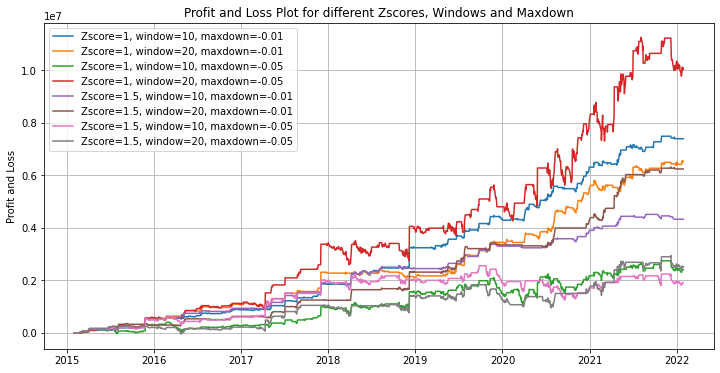

In [161]:
# 绘制不同参数PNL曲线图
plt.figure(figsize=(12,6))
plt.plot((test1['Portfolio Returns']).cumsum(),label='Zscore=1, window=10, maxdown=-0.01')    
plt.plot((test2['Portfolio Returns']).cumsum(),label='Zscore=1, window=20, maxdown=-0.01')    
plt.plot((test3['Portfolio Returns']).cumsum(),label='Zscore=1, window=10, maxdown=-0.05')
plt.plot((test4['Portfolio Returns']).cumsum(),label='Zscore=1, window=20, maxdown=-0.05')    
plt.plot((test5['Portfolio Returns']).cumsum(),label='Zscore=1.5, window=10, maxdown=-0.01')    
plt.plot((test6['Portfolio Returns']).cumsum(),label='Zscore=1.5, window=20, maxdown=-0.01')    
plt.plot((test7['Portfolio Returns']).cumsum(),label='Zscore=1.5, window=10, maxdown=-0.05')
plt.plot((test8['Portfolio Returns']).cumsum(),label='Zscore=1.5, window=20, maxdown=-0.05')    
plt.ylabel('Profit and Loss')
plt.title('Profit and Loss Plot for different Zscores, Windows and Maxdown')
plt.legend()
plt.grid()
plt.show()